<a href="https://colab.research.google.com/github/rahul-kulkarni/w266-spring-2020-project/blob/master/CodaQuestionSimilarity-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

We implement the Question Similarity task in this notebook. The question similarity dataset generated from our EDA that labels the duplicate questions is used to train our model. We describe our three models starting with a baseline version.

In [22]:
from __future__ import print_function
import os
import datetime, time, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False # Disable the warnings

import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Dot, BatchNormalization, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping
tf.get_logger().setLevel('ERROR')

#from google.colab import drive 
#drive.mount('/content/gdrive')


## Load the duplicate questions dataset

In [23]:
dupe_df = pd.read_csv('data/dupe_df_100k.csv')
#dup_df_path ='gdrive/My Drive/Colab Notebooks/coda/data/dupe_df_100k.csv'
#dupe_df = pd.read_csv(dup_df_path)
dupe_df.dropna(inplace=True)

### Print Sample Duplicates

In [24]:
dupe_df.head(10)

,title,dupe_title,is_dupe
0,python writing json file,write json data file,1
1,read 5th line python csv module,best way access nth line csv file,1
2,print list without showing brackets output pyt...,adding numbers list togethernot summing python...,1
3,numpy create masked array lists unequal size,convert pad list numpy array,1
4,wrong timezone 30min instead 1hr,datetime timezone conversion using pytz,1
5,python open window set parent insensitive,pygobject glade send window front,1
6,import mysqldb fails os x 1082 mountain lion p...,install mysqldb python data access library mys...,1
7,python saving api result json file,write json data file,1
8,delimiter python3x regex pattern,regex differ php python,1
9,python matplotlib create subplots,remove gaps subplots matplotlib,1


### Print sample non-duplicates

In [25]:
dupe_df.tail(10)

,title,dupe_title,is_dupe
162750,assigning name lines read file,python code generate alternative python code,0
162751,assigning name lines read file,sum numbers 1 5 loop,0
162752,assigning name lines read file,compare elements position array,0
162753,assigning name lines read file,term bound means class method,0
162754,assigning name lines read file,python list element syntax,0
162755,assigning name lines read file,store input user specified index array python,0
162756,assigning name lines read file,convert longitude latitude country city,0
162757,assigning name lines read file,python lists two functions firsti think second,0
162758,assigning name lines read file,replace part file another file,0
162759,assigning name lines read file,loop lists function,0


## Build our X and y

In [26]:
# Get Labels
y = dupe_df['is_dupe'].to_numpy()

# Question title and dupe title
dupe_df = dupe_df.drop(['is_dupe'], axis = 1)
X = dupe_df.to_numpy()

print(y.shape, X.shape)

(162677,) (162677, 2)


## Validate using Universal Sentence Encoder 

### Load universal sentence encoder (USE) from TF HUB

In [0]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [18]:
# Build a small list of question titles and corrosponding duplicates
dupe_df_sample = dupe_df.sample(8)
messages = []
for i, row in dupe_df_sample.iterrows():
    messages.append(row['title'])
    messages.append(row['dupe_title'])

message_embeddings = embed(messages)
print(message_embeddings.shape)
      
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Question: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

(16, 512)
Question: splash screen move bar
Embedding size: 512
Embedding: [-0.04143122583627701, 0.039064109325408936, -0.04476099833846092, ...]

Question: tkinter mouse drag window without borders eg overridedirect1
Embedding size: 512
Embedding: [0.02780076675117016, -0.06536060571670532, 0.058783818036317825, ...]

Question: pandas groupbynth function abnormal behaviour nan
Embedding size: 512
Embedding: [0.021077416837215424, -0.06760544329881668, 0.03229514881968498, ...]

Question: pandas sum time interval group excluding overlaps
Embedding size: 512
Embedding: [-0.046837177127599716, -0.07595676183700562, 0.03853143751621246, ...]

Question: robustly parse wikitables rowspan colspan pandas dataframe
Embedding size: 512
Embedding: [0.015776928514242172, -0.06958452612161636, 0.03150045871734619, ...]

Question: tr rowspan
Embedding size: 512
Embedding: [0.04754408821463585, -0.06223956495523453, 0.08156958222389221, ...]

Question: inserting data dictionary raw_input dynamically

### Plot a similarity matrix 

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


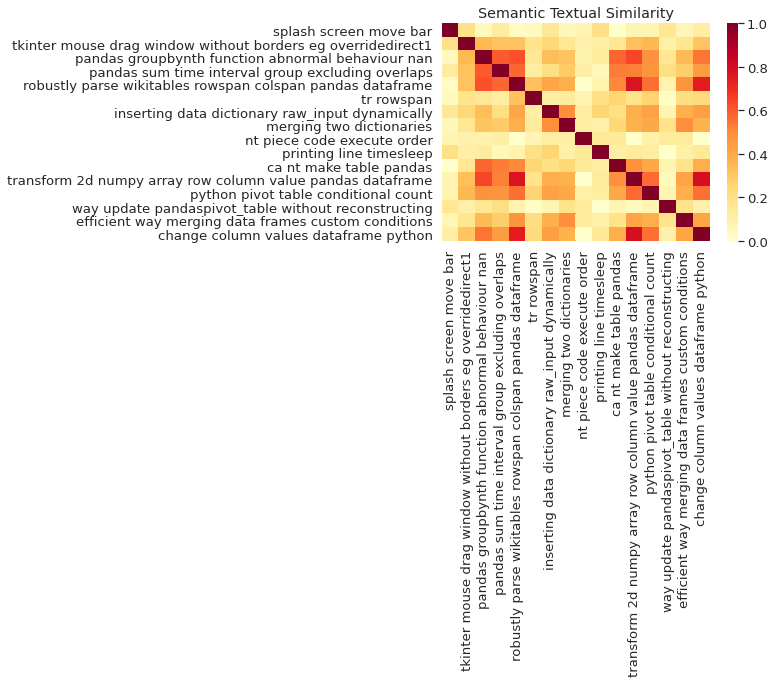

In [20]:
plot_similarity(messages, message_embeddings, 90)

## Build a Train and Test set

In [27]:
# Split into train and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)
print("X_train", X_train.shape)
print("Y_train", y_train.shape)

# Keep separated train and test sets
X_train_split = X_train.copy()
X_test_split = X_test.copy()
y_train_split = y_train.copy()
y_test_split = y_test.copy()

print("X_train_split", X_train_split.shape)
print("X_test_split", X_test_split.shape)
print("y_train_split", y_train_split.shape)
print("y_test_split", y_test_split.shape)

X_train = X_train[:,0] + X_train[:,1].astype('str')
print("X_train Concatenated with Q1, Q2", X_train.shape)
X_test = X_test[:,0] + X_test[:,1].astype('str')
print("X_test  Concatenated with Q1, Q2", X_test.shape)

print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (130141, 2)
Y_train (130141,)
X_train_split (130141, 2)
X_test_split (32536, 2)
y_train_split (130141,)
y_test_split (32536,)
X_train Concatenated with Q1, Q2 (130141,)
X_test  Concatenated with Q1, Q2 (32536,)
y_train (130141,)
y_test (32536,)


## Build Model 

Here we build three models, the first one is a simple baseline model, model 1 is a improvement over the baseline and model 2 is our final optimized model

### Baseline Model: USE with Cosine Similarity

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

In [0]:
Q_train = X_train_split[:, 0].tolist()
D_train = X_train_split[:, 1].tolist()

In [0]:
X_train_ue = []

for i in range(len(Q_train)):
    q = [Q_train[i]]
    d = [D_train[i]]
    X_train_ue.append(cosine_similarity(embed(tf.cast(q, tf.string)), embed(tf.cast(d, tf.string))))

In [0]:
X_train_ue_np = np.array(X_train_ue) 
X_train_ue_np = X_train_ue_np[:, 0]

In [0]:
Q_test = X_test_split[:, 0].tolist()
D_test = X_test_split[:, 1].tolist()

In [0]:
X_test_ue = []

for i in range(len(Q_test)):
    q = [Q_test[i]]
    d = [D_test[i]]
    X_test_ue.append(cosine_similarity(embed(tf.cast(q, tf.string)), embed(tf.cast(d, tf.string))))

In [0]:
X_test_ue_np = np.array(X_test_ue)
X_test_ue_np = X_test_ue_np[:, 0]

In [0]:
clf = LogisticRegression(random_state=0).fit(X_train_ue_np, y_train)

In [32]:
clf.score(X_test_ue_np, y_test)

0.6487890336857635

### Model-1: Two Tower Dot Product with USE

In [28]:
def plot_model(model_name):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(model_name + 'model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + 'model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [0]:
USE_EMBEDDING_SIZE = 512
VALIDATION_SPLIT = 0.1
DROPOUT = 0.2
BATCH_SIZE = 200
#MODEL_WEIGHTS_FILE = 'data/coda_model_two_tower.h5'
MODEL_WEIGHTS_FILE="gdrive/My Drive/Colab Notebooks/coda/data/CODA_QS_TWO_TOWER"

def build_two_tower_model(activation_function='relu', 
                  optimizer='adam', 
                  kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                  bias_initializer='zeros',
                  dropout=0.2):

    # Define Input Layer
    Q0 = Input(shape=(1,), dtype="string")
    
    Q1 = Input(shape=(1,), dtype="string")
        
    # Define an embedding layer using USE
    Q0_e = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(Q0)
    
    # Define an embedding layer using USE
    Q1_e = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(Q1)
    
    # Define one hidden layer
    dense_layer = Dense(100, 
                        activation=activation_function,
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=bias_initializer,
                        name='layer-1')
    
    # Feed the answer embedding to a dense layer
    Q1_prime = dense_layer(Q1_e)
    Q1_prime = Dropout(dropout)(Q1_prime)
    Q1_prime = BatchNormalization()(Q1_prime)
    
    # Define a second hidden layer
    dense_layer_2 = Dense(512,
                          activation=activation_function,
                          kernel_initializer=kernel_initializer, 
                          bias_initializer=bias_initializer,
                          name='layer-2')
    
    # Feed the previous layer output to dense 2 layer               
    Q1_prime = dense_layer_2(Q1_prime)
    Q1_prime = Dropout(dropout)(Q1_prime)
    Q1_prime = BatchNormalization()(Q1_prime)
    
    # Dot product of Question Embedding and Answer prime
    QA = Dot(axes = 1)([Q0_e,Q1_prime])
    
    result = Reshape((1,), input_shape=(1,1))(QA)
    
    # Final layer
    probs  = Dense(1, activation='sigmoid')(result)

    # Build and compile model, input Question and Answer body 
    two_tower_model = Model(inputs=[Q0, Q1], outputs=probs)
    
    two_tower_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return two_tower_model

In [74]:
two_tower_model = build_two_tower_model()

two_tower_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 512)          0           input_12[0][0]                   
__________________________________________________________________________________________________
layer-1 (Dense)                 (None, 100)          51300       lambda_11[0][0]                  
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 100)          0           layer-1[0][0]                    
____________________________________________________________________________________________

In [40]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=2)]

history = two_tower_model.fit([X_train_split[:, 0], X_train_split[:, 1]], 
                    y_train_split, 
                    epochs=25,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
two_tower_model.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-16 16:32:43.168649
Epoch 1/25


586/586 - 16s - loss: 0.4089 - accuracy: 0.8121 - val_loss: 0.3115 - val_accuracy: 0.8738
Epoch 2/25


586/586 - 16s - loss: 0.2707 - accuracy: 0.8902 - val_loss: 0.2162 - val_accuracy: 0.9172
Epoch 3/25


586/586 - 16s - loss: 0.2218 - accuracy: 0.9123 - val_loss: 0.1901 - val_accuracy: 0.9295
Epoch 4/25


586/586 - 16s - loss: 0.1931 - accuracy: 0.9241 - val_loss: 0.1730 - val_accuracy: 0.9345
Epoch 5/25


586/586 - 16s - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.1640 - val_accuracy: 0.9396
Epoch 6/25


586/586 - 16s - loss: 0.1572 - accuracy: 0.9391 - val_loss: 0.1560 - val_accuracy: 0.9429
Epoch 7/25


586/586 - 16s - loss: 0.1450 - accuracy: 0.9445 - val_loss: 0.1529 - val_accuracy: 0.9441
Epoch 8/25


586/586 - 16s - loss: 0.1370 - accuracy: 0.9464 - val_loss: 0.1506 - val_accuracy: 0.9443
Epoch 9/25


586/586 - 16s - loss: 0.1294 - accuracy: 0.9504 - val_loss: 0.1483 - val_accuracy: 0.9461
Epoch 10/25


586/586 - 16s - loss: 0.1241 - accuracy: 0.9521 - val_loss: 0.1437 - val_accuracy: 0.9475
Epoch 11/25


586/586 - 16s - loss: 0.1180 - accuracy: 0.9547 - val_loss: 0.1461 - val_accuracy: 0.9468
Epoch 12/25


586/586 - 16s - loss: 0.1112 - accuracy: 0.9578 - val_loss: 0.1470 - val_accuracy: 0.9489
Training ended at 2020-04-16 16:36:00.470062
Minutes elapsed: 3.288354


In [0]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 21 = 0.9519


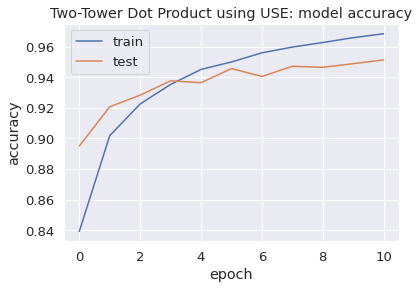

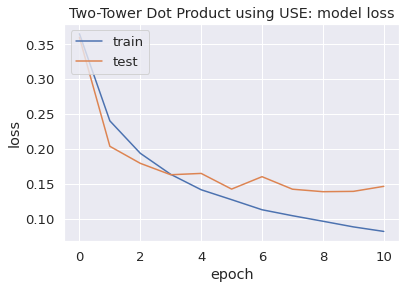

In [67]:
plot_model("Two-Tower Dot Product using USE: ")

In [53]:
two_tower_model.load_weights(MODEL_WEIGHTS_FILE)  
predicts = two_tower_model.predict([X_test_split[:, 0], X_test_split[:, 1]])
print('\n# Evaluate on test data')
results = two_tower_model.evaluate([X_test_split[:, 0], X_test_split[:, 1]], y_test_split)
print('test loss, test acc:', results)


# Evaluate on test data
1017/1017 [==============================] - 7s 7ms/step - loss: 0.1477 - accuracy: 0.9461
test loss, test acc: [0.14773626625537872, 0.9461212158203125]


### Model-2 : Cross Attention with Concatenation with USE

In [0]:
USE_EMBEDDING_SIZE = 512
VALIDATION_SPLIT = 0.1
DROPOUT = 0.2
BATCH_SIZE = 256
#MODEL_WEIGHTS_FILE = 'data/coda_model_two_tower.h5'
MODEL_WEIGHTS_FILE="gdrive/My Drive/Colab Notebooks/coda/data/CODA_QS_CROSS_ATTN"


def build_cross_attn_model(activation_function='relu', 
                  optimizer='adam', 
                  kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                  bias_initializer='zeros',
                  dropout=0.2):

    # Define Input Layer
    input_text = Input(shape=(1,), dtype="string")
    
    # Define an embedding layer using USE
    embedding = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(input_text)
    
    # Define one hidden layer
    dense_layer = Dense(256, 
                          activation=activation_function,
                          kernel_initializer=kernel_initializer, 
                          bias_initializer=bias_initializer,
                          name='layer-1')
    
    # Feed the embeddings to the dense layer
    dense_output = dense_layer(embedding)
    
    # Use dropout to avoid overfit 
    dropout_output = Dropout(dropout)(dense_output)

    #Batch normalize
    batchnormalized_output = BatchNormalization()(dropout_output)
    
    # Define a second hidden layer
    dense_layer_2 = Dense(256,
                          activation=activation_function,
                          kernel_initializer=kernel_initializer, 
                          bias_initializer=bias_initializer,
                          name='layer-2')
    
    # Feed the previous layer output to dense 2 layer                
    dense_output_2 = dense_layer_2(batchnormalized_output)
    
    # Use dropout to avoid overfit 
    dropout_output_2 = Dropout(dropout)(dense_output_2)
    
    #Batch normalize
    batchnormalized_output_2 = BatchNormalization()(dropout_output_2)
    
    # Final sigmoid layer for prediction probablities
    pred = Dense(1, activation='sigmoid')(batchnormalized_output_2)
    
    # Build and compile model
    cross_attn_model = Model(inputs=[input_text], outputs=pred)
    
    cross_attn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return cross_attn_model


In [75]:
cross_attn_model = build_cross_attn_model()

cross_attn_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 512)               0         
_________________________________________________________________
layer-1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
layer-2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0   

#### Train the model

In [59]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),
              EarlyStopping(monitor='val_loss', patience=2)]

history = cross_attn_model.fit(X_train, 
                    y_train, 
                    epochs=30,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
cross_attn_model.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-16 16:47:09.464449
Epoch 1/30


458/458 - 14s - loss: 0.3649 - accuracy: 0.8392 - val_loss: 0.3598 - val_accuracy: 0.8950
Epoch 2/30


458/458 - 14s - loss: 0.2403 - accuracy: 0.9018 - val_loss: 0.2039 - val_accuracy: 0.9206
Epoch 3/30


458/458 - 13s - loss: 0.1939 - accuracy: 0.9225 - val_loss: 0.1796 - val_accuracy: 0.9282
Epoch 4/30


458/458 - 14s - loss: 0.1638 - accuracy: 0.9353 - val_loss: 0.1633 - val_accuracy: 0.9376
Epoch 5/30


458/458 - 13s - loss: 0.1418 - accuracy: 0.9451 - val_loss: 0.1652 - val_accuracy: 0.9364
Epoch 6/30


458/458 - 14s - loss: 0.1276 - accuracy: 0.9499 - val_loss: 0.1428 - val_accuracy: 0.9456
Epoch 7/30


458/458 - 13s - loss: 0.1132 - accuracy: 0.9559 - val_loss: 0.1605 - val_accuracy: 0.9405
Epoch 8/30


458/458 - 14s - loss: 0.1047 - accuracy: 0.9597 - val_loss: 0.1426 - val_accuracy: 0.9471
Epoch 9/30


458/458 - 14s - loss: 0.0968 - accuracy: 0.9626 - val_loss: 0.1390 - val_accuracy: 0.9464
Epoch 10/30


458/458 - 13s - loss: 0.0887 - accuracy: 0.9658 - val_loss: 0.1395 - val_accuracy: 0.9488
Epoch 11/30


458/458 - 14s - loss: 0.0822 - accuracy: 0.9684 - val_loss: 0.1467 - val_accuracy: 0.9513
Training ended at 2020-04-16 16:49:41.484847
Minutes elapsed: 2.533670


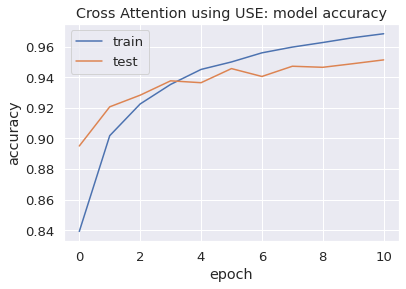

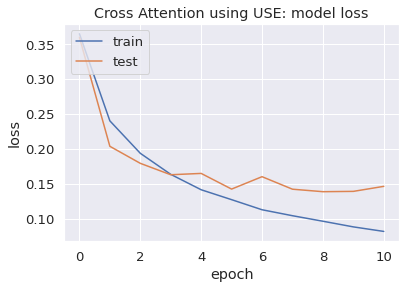

In [66]:
plot_model("Cross Attention using USE: ")

In [61]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 11 = 0.9513


#### Test the model

In [64]:
cross_attn_model.load_weights(MODEL_WEIGHTS_FILE)  
predicts = cross_attn_model.predict(X_test)
print('\n# Evaluate on test data')
results = cross_attn_model.evaluate(X_test, y_test)
print('test loss, test acc:', results)


# Evaluate on test data
1017/1017 [==============================] - 8s 8ms/step - loss: 0.1493 - accuracy: 0.9490
test loss, test acc: [0.1492963433265686, 0.9490103125572205]


### Model-3: Bert Based Cross Attention 

In [21]:
!pip install bert-tensorflow
!pip install bert-for-tf2
!pip install sentencepiece

In [35]:
import bert
from bert.tokenization.bert_tokenization import FullTokenizer
import sys
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.1.0
Hub version:  0.8.0


In [30]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

In [43]:
MAX_SEQ_LEN=128
BATCH_SIZE=200
VALIDATION_SPLIT=0.1
DROPOUT=0.2
MODEL_WEIGHTS_FILE="gdrive/My Drive/Colab Notebooks/coda/data/CODA_QS_BERT"


def build_bert_model(activation_function='relu', 
                  optimizer='adam', 
                  #kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                  #bias_initializer='zeros',
                  dropout=0.2):

    input_word_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    # Final sigmoid layer for prediction probablities
    pred = Dense(1, activation='sigmoid')(pooled_output)
    
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
    
    opt = Adam(lr=5e-5)
    
    bert_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return bert_model

In [44]:
bert_model = build_bert_model()

bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [36]:
#FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

In [37]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [38]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [39]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

In [40]:
def create_input_array(sentences):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [41]:
inputs=create_input_array(X_train)

100%|██████████| 130141/130141 [00:37<00:00, 3448.67it/s]


In [45]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True), 
             EarlyStopping(monitor='val_loss', patience=2)]
history = bert_model.fit(inputs, 
                    y_train, 
                    epochs=3,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks
                    )
bert_model.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-17 16:31:08.463756
Train on 117126 samples, validate on 13015 samples
Epoch 1/3
117126/117126 - 18382s - loss: 0.1056 - accuracy: 0.9566 - val_loss: 0.0374 - val_accuracy: 0.9875
Epoch 2/3
117126/117126 - 18074s - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0248 - val_accuracy: 0.9933
Epoch 3/3
117126/117126 - 17976s - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0217 - val_accuracy: 0.9942
Training ended at 2020-04-18 07:38:21.567597
Minutes elapsed: 907.218394


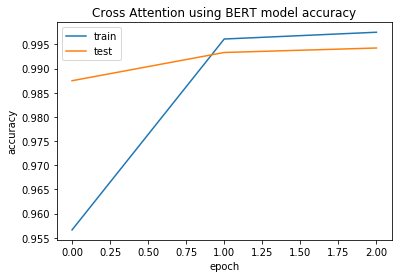

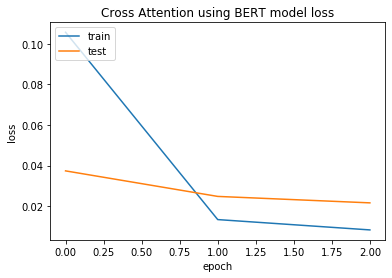

In [46]:
plot_model("Cross Attention using BERT ")

In [47]:
inputs=create_input_array(X_test)
bert_model.load_weights(MODEL_WEIGHTS_FILE)  
predicts = bert_model.predict(inputs)
print('\n# Evaluate on test data')
results = bert_model.evaluate(inputs, y_test)
print('test loss, test acc:', results)

100%|██████████| 32536/32536 [00:09<00:00, 3586.37it/s]



# Evaluate on test data
32536/32536 [==============================] - 1670s 51ms/sample - loss: 0.0205 - accuracy: 0.9948
test loss, test acc: [0.020538683364120063, 0.9948365]
